In [1]:
# Use below code if in the src/ directory
# import sys
# sys.path.append('data_preprocessing')
# import data_preprocessing.normalize as normalize
# import data_preprocessing.outliers as outliers
# import data_preprocessing.summary as summary

import summary
import outliers
import normalize

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.externals import joblib
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV, learning_curve, train_test_split

# Load and preprocess data

In [2]:
train_data = pd.read_csv('../../data/input/ames_train.csv')
test_data = pd.read_csv('../../data/input/ames_test.csv')

train_gdata = pd.read_csv('../../data/input/ames_geodemo_train.csv')
test_gdata = pd.read_csv('../../data/input/ames_geodemo_test.csv')

In [3]:
train_data.set_index('Id', inplace=True)
train_data.drop(['PID'], axis=1, inplace=True)

test_data.set_index('Id', inplace=True)
test_data.drop(['PID'], axis=1, inplace=True)

train_gdata.set_index('Id', inplace=True)
train_gdata.drop(['PID', 'Latitude', 'Longitude', 'county', 'tract', 'blkgrp'], axis=1, inplace=True)

test_gdata.set_index('Id', inplace=True)
test_gdata.drop(['PID', 'Latitude', 'Longitude', 'county', 'tract', 'blkgrp'], axis=1, inplace=True)

In [4]:
train_data = normalize.fill_in_missing_values(train_data)
train_data = outliers.remove_outliers(train_data)
#train_data = normalize.normalize(train_data)

test_data = normalize.fill_in_missing_values(test_data)
test_data = outliers.remove_outliers(test_data)
#test_data = normalize.normalize(test_data)

train_gdata = normalize.fill_in_missing_values(train_gdata)
train_gdata = outliers.remove_outliers(train_gdata)
#train_gdata = normalize.normalize(train_gdata)

test_gdata = normalize.fill_in_missing_values(test_gdata)
test_gdata = outliers.remove_outliers(test_gdata)
#test_gdata = normalize.normalize(test_gdata)

In [5]:
# Custom preprocessing here

# Your Algorithm Here
Use code here as needed.

In [5]:
# Remove categorical data
train_data = train_data.select_dtypes(include=[np.number])
test_data = test_data.select_dtypes(include=[np.number])
train_gdata = train_gdata.select_dtypes(include=[np.number])
test_gdata = test_gdata.select_dtypes(include=[np.number])

print(train_data.shape)
print(test_data.shape)
print(train_gdata.shape)
print(test_gdata.shape)

(2306, 37)
(574, 37)
(2306, 78)
(574, 78)


In [6]:
# Split training set into train and validation set
X_train, X_val, y_train, y_val = train_test_split(train_data.loc[:, train_data.columns != 'SalePrice'], 
                                                  train_data['SalePrice'],
                                                  test_size=0.2, random_state=42)

X_train = X_train.values
X_val = X_val.values
y_train = y_train.values
y_val = y_val.values

print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

print(np.any(np.isnan(y_train)))

(1844, 36)
(462, 36)
(1844,)
(462,)
False


In [7]:
# Split geodemo training set into train and validation set
X_train_geo, X_val_geo, y_train_geo, y_val_geo = train_test_split(train_gdata.loc[:, train_gdata.columns != 'SalePrice'], 
                                                                  train_gdata['SalePrice'],
                                                                  test_size=0.2, random_state=42)

X_train_geo = X_train_geo.values
X_val_geo = X_val_geo.values
y_train_geo = y_train_geo.values
y_val_geo = y_val_geo.values

print(X_train_geo.shape)
print(X_val_geo.shape)
print(y_train_geo.shape)
print(y_val_geo.shape)

print(np.any(np.isnan(y_train_geo)))

(1844, 77)
(462, 77)
(1844,)
(462,)
False


In [8]:
from sklearn.linear_model import Lasso

In [23]:
# Hyperparameter tuning
param_grid = [
  {'alpha': [0.2, 0.5, 1.0], 'max_iter': [100, 300, 1000]}
]

clf = GridSearchCV(Lasso(), param_grid, cv=5,
                   scoring='r2')
clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
print()

Best parameters set found on development set:

{'alpha': 1.0, 'max_iter': 100}

Grid scores on development set:

0.875 (+/-0.017) for {'alpha': 0.2, 'max_iter': 100}
0.875 (+/-0.017) for {'alpha': 0.2, 'max_iter': 300}
0.875 (+/-0.017) for {'alpha': 0.2, 'max_iter': 1000}
0.875 (+/-0.017) for {'alpha': 0.5, 'max_iter': 100}
0.875 (+/-0.017) for {'alpha': 0.5, 'max_iter': 300}
0.875 (+/-0.017) for {'alpha': 0.5, 'max_iter': 1000}
0.875 (+/-0.017) for {'alpha': 1.0, 'max_iter': 100}
0.875 (+/-0.017) for {'alpha': 1.0, 'max_iter': 300}
0.875 (+/-0.017) for {'alpha': 1.0, 'max_iter': 1000}



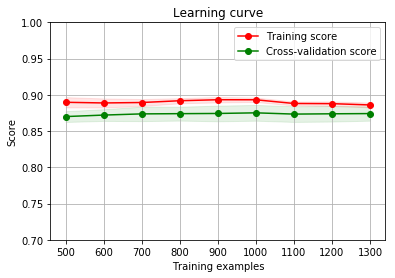

In [24]:
# Learning curve
import warnings
warnings.filterwarnings("ignore")

train_sizes, train_scores, valid_scores = learning_curve(clf, X_train, y_train, train_sizes=range(500, 1400, 100), cv=5)

plt.figure()
plt.title('Learning curve')
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.ylim([0.7, 1.0])

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std,
                 valid_scores_mean + valid_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, valid_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best")
plt.show()

In [9]:
# Predictions on validation set
lr = Lasso(alpha=1.0, max_iter=100)
lr.fit(X_train,y_train)
y_val_pred = lr.predict(X_val)
print('R2 score:', np.round(r2_score(y_val, y_val_pred), 4))
print('Median margin of error:', np.median(np.abs((y_val_pred - y_val) / y_val)))

R2 score: 0.8771
Median margin of error: 0.0912867017082


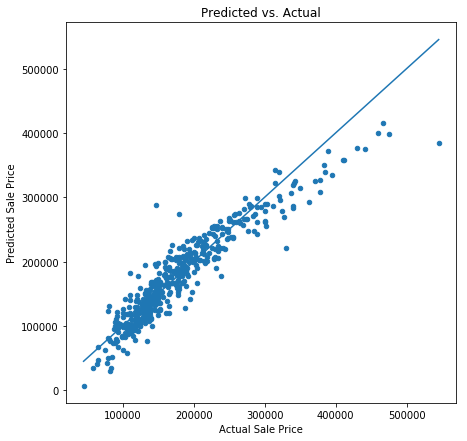

In [10]:
# Plot predictions vs validation set
summary.pred_vs_actual_plot(y_val_pred, y_val)

# Output results
We want to output models and predictions on the test set with and without geodemos for reporting and comparison

In [11]:
# Test data
X_test = test_data.loc[:, test_data.columns != 'SalePrice']
y_test = test_data['SalePrice']

# Train final model
lr = Lasso(alpha=1.0, max_iter=100)
lr.fit(np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)))
pred = lr.predict(X_test)
print('R2 score:', np.round(r2_score(y_test, pred), 4))
print('Median margin of error:', np.median(np.abs((pred - y_test) / y_test)))

# Output predictions
pred_df = pd.DataFrame(data={'predictions': pred}, index=test_data.index)
pred_df.to_csv('../../data/output/pred_linear_lasso.csv')

# Pickle final model
joblib.dump(lr, '../../models/model_linear_lasso.pkl')

R2 score: 0.8784
Median margin of error: 0.0882033358499


['../../models/model_linear_lasso.pkl']

In [12]:
# Test data with geodemos
X_test_geo = test_gdata.loc[:, test_gdata.columns != 'SalePrice']
y_test_geo = test_gdata['SalePrice']

# Train final model
lr = Lasso(alpha=1.0, max_iter=100)
lr.fit(np.concatenate((X_train_geo, X_val_geo)), np.concatenate((y_train_geo, y_val_geo)))
pred = lr.predict(X_test_geo)
print('R2 score:', np.round(r2_score(y_test_geo, pred), 4))
print('Median margin of error:', np.median(np.abs((pred - y_test_geo) / y_test_geo)))

# Output predictions
pred_df = pd.DataFrame(data={'predictions': pred}, index=test_gdata.index)
pred_df.to_csv('../../data/output/pred_linear_lasso_geo.csv')

# Pickle final model
joblib.dump(lr, '../../models/model_linear_lasso_geo.pkl')

R2 score: 0.8907
Median margin of error: 0.0854852865334


D:\ProgramData\Anaconda3\envs\school\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


['../../models/model_linear_lasso_geo.pkl']